In [1]:
# importing sys
import sys
  
# adding srcpy to the system path
sys.path.insert(0, "/Users/charles/Desktop/DSAI/6_DataScience/project/DSP/20221/srcpy")

import data_proc, feature_proc

# Auto reload: watch a directory for changed files and restarts a process when the change is detected
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None
pd.options.display.float_format

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
mpl.style.use("ggplot")
pylab.rcParams["figure.figsize"] = 8 , 6

import seaborn as sns
sns.set_style("white")

from pandas_profiling import ProfileReport

In [2]:
df= data_proc.load_training_data("/Users/charles/Desktop/DSAI/6_DataScience/project/DSP/20221/data/zillow.csv")
data_proc.rename_columns(df)
df = data_proc.del_dup(df)
#df = data_proc.encode_cat(df)
#df = data_proc.convert_true_to_float(df, "has_add_attributions")
df.head()

,price,status,add_attr,state,lat,long,bath,bed,living,lot_a,tax_assessed,fireplace,parking,covered,garage,total_spaces,subtype,year,sewer,water,app,heating,cooling,stories,materials,roof,foundation,interior
0,274000,House for sale,True,NY,40.675730,-73.822350,1,3,1556,2400.0,0,none,Garage - Detached,1.750,1.595,1.945,none,1930.0,none,none,none,none,none,0.0,none,none,none,none
1,270000,House for sale,True,NY,40.670036,-73.780450,2,4,1920,3998.0,678000,none,none,1.660,1.535,2.160,none,1950.0,none,none,microwave,none,none,0.0,none,none,none,none
2,899000,House for sale,True,NY,40.524227,-74.215790,3,3,2532,6903.0,637000,none,Detache,1.935,2.000,2.000,Single Family - Detached,1899.0,Public Sewer,none,dishwasher,hot water,Units,2.0,none,none,none,none
3,1390000,House for sale,True,NY,40.721615,-73.820755,4,4,1915,2697.0,894000,none,none,1.695,1.655,3.915,none,1945.0,none,none,dryer,none,none,0.0,none,none,none,none
5,1380000,House for sale,True,NY,40.604470,-73.943960,4,3,1800,2000.0,0,none,Shared Drivewa,1.700,1.000,2.160,Single Family Residence,1930.0,Public Sewer,Public,dishwasher,natural gas,Wall Unit(s),2.0,brick,none,none,Formal Dining Roo


In [3]:
# Maps 
import plotly.express as px
import pandas as pd

color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df, 
                        lat="lat", 
                        lon="long", 
                        color_continuous_scale=color_scale,
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Process outliers, OOD, missing

In [4]:
#report = ProfileReport(df, title = "Report Zillow")
#report.to_notebook_iframe()
#report.to_file("Report_Zillow_processP1.html")

## Continous

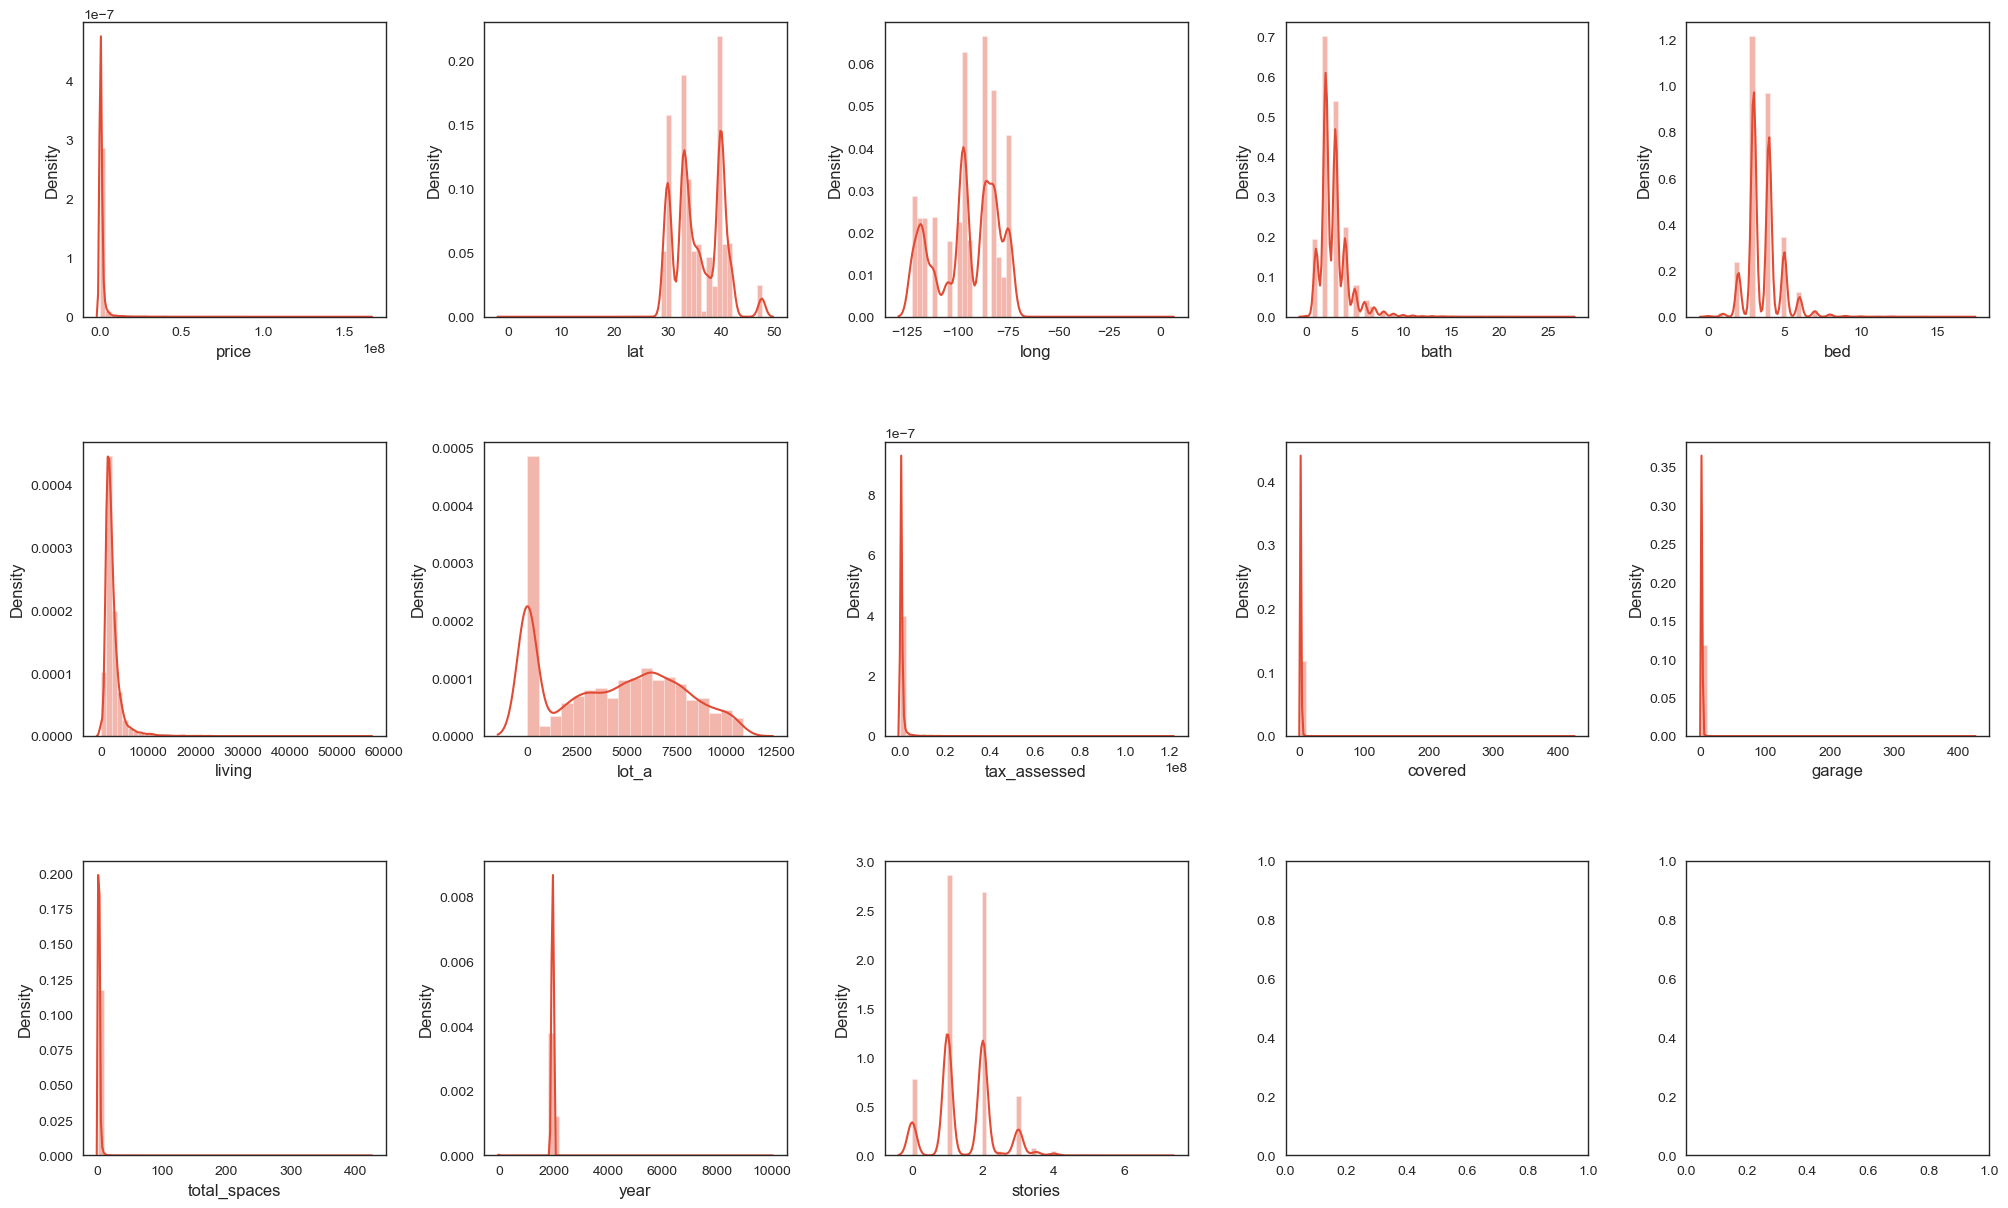

In [5]:
# Destiny
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, axs = plt.subplots(nrows = 3, ncols = 5, figsize=(20, 12))
index = 0
axs = axs.flatten()
for k,v in df.select_dtypes(include=["number"]).items():
    sns.distplot(v, ax=axs[index])
    index += 1
    if index == 13:
        break
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show();

In [6]:
df.select_dtypes(include=["number"]).columns

Index(['price', 'lat', 'long', 'bath', 'bed', 'living', 'lot_a',
       'tax_assessed', 'covered', 'garage', 'total_spaces', 'year', 'stories'],
      dtype='object')

### price 

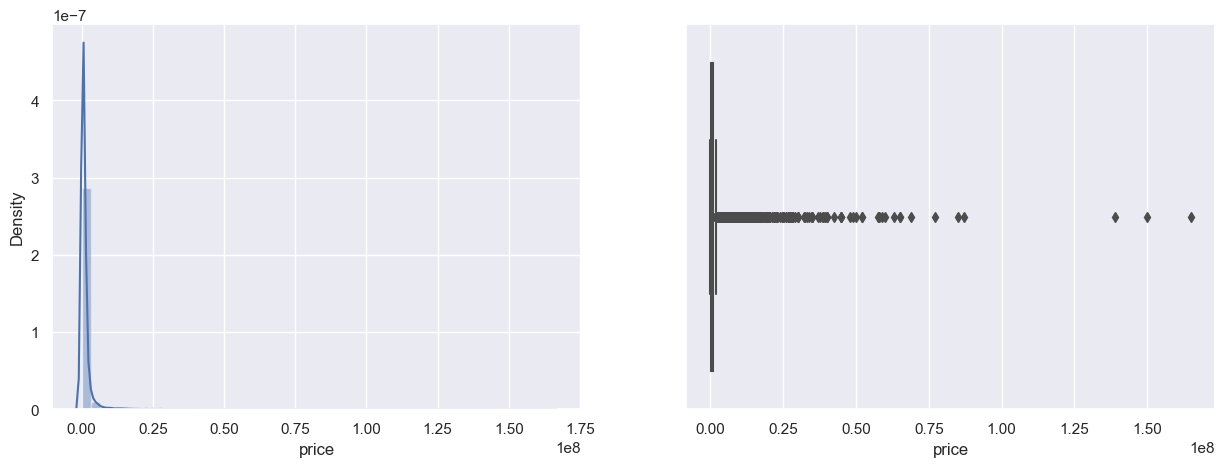

In [7]:
# Box Plot 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Total Room Visualize 
import seaborn as sns
sns.set_theme()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(df["price"],  ax=axs[0]);
sns.boxplot(df["price"],  ax=axs[1]);

In [8]:
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin

def find_boxplot_boundaries(df_col):
    Q1 = df_col.quantile(0.25)
    Q3 = df_col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR   # ≥ 0 for this feature
    upper = Q3 + 1.5 * IQR
    return lower, upper

# OOP Inheritance
class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lower = None
        self.upper = None

    def fit(self, df_col):
        self.lower, self.upper = find_boxplot_boundaries(df_col)
        return self

    def transform(self, df_col):
        return df_col.clip(self.lower, self.upper)

In [9]:
find_boxplot_boundaries(df["price"])

(-705280.0, 1999168.0)

In [10]:
# Limit price 4.000.000
df = df[df['price'] <= 4000000]
  
# Print the shape of the dataframe
print(len(df))

12704


### bath & bed

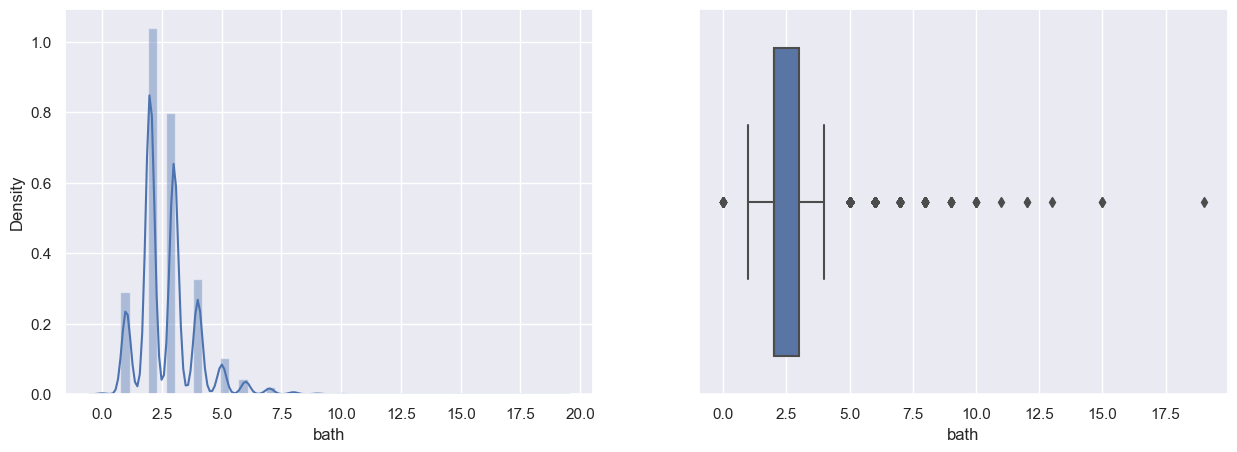

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(df["bath"],  ax=axs[0]);
sns.boxplot(df["bath"],  ax=axs[1]);

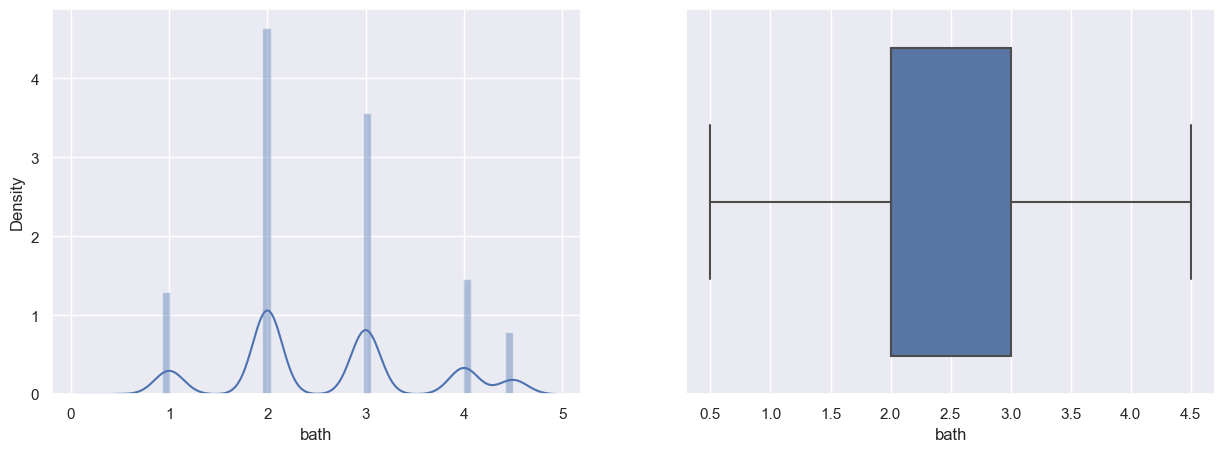

In [12]:
#clipped_total_rooms = BoxplotOutlierClipper().fit(df_housing["total_rooms"]).transform(df_housing["total_rooms"])
clipped_bath = BoxplotOutlierClipper().fit_transform(df["bath"])

# Plot new data (clipped)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(clipped_bath, ax = axs[0])
sns.boxplot(clipped_bath, ax = axs[1]);

# convert to df
df["bath"] = clipped_bath

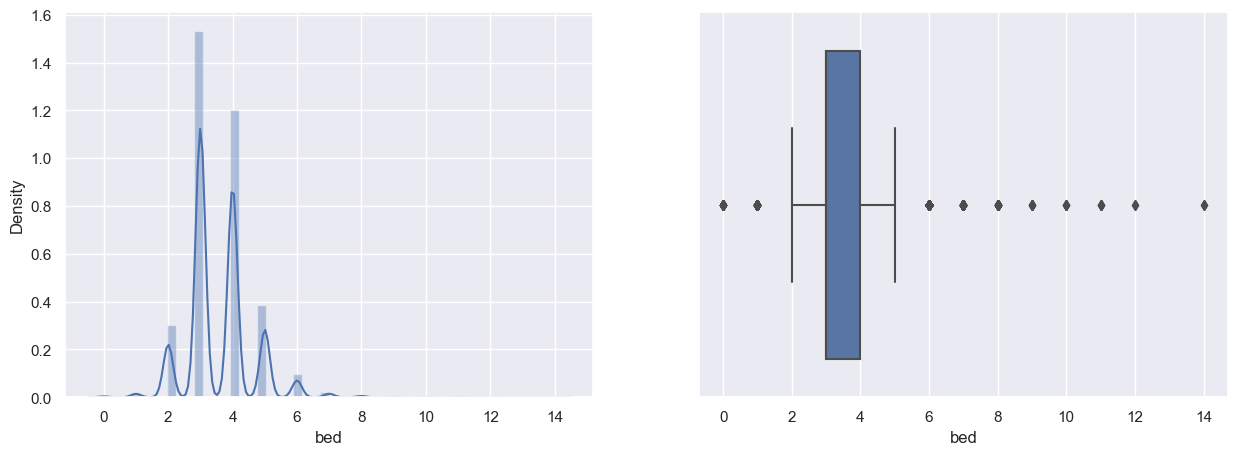

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(df["bed"],  ax=axs[0]);
sns.boxplot(df["bed"],  ax=axs[1]);

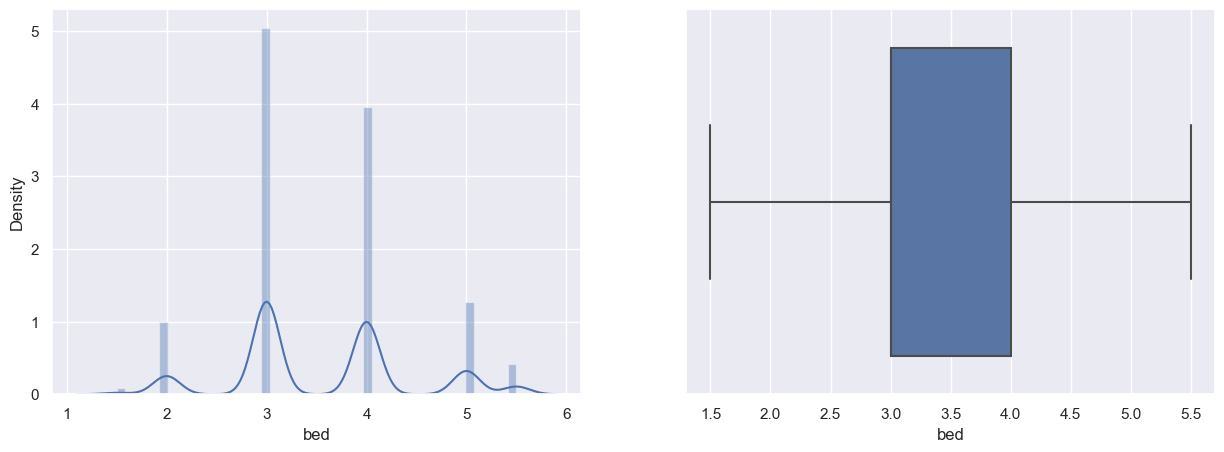

In [14]:
#clipped_total_rooms = BoxplotOutlierClipper().fit(df_housing["total_rooms"]).transform(df_housing["total_rooms"])
clipped_bed = BoxplotOutlierClipper().fit_transform(df["bed"])

# Plot new data (clipped)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(clipped_bed, ax = axs[0])
sns.boxplot(clipped_bed, ax = axs[1]);

df["bath"] = clipped_bed

### living

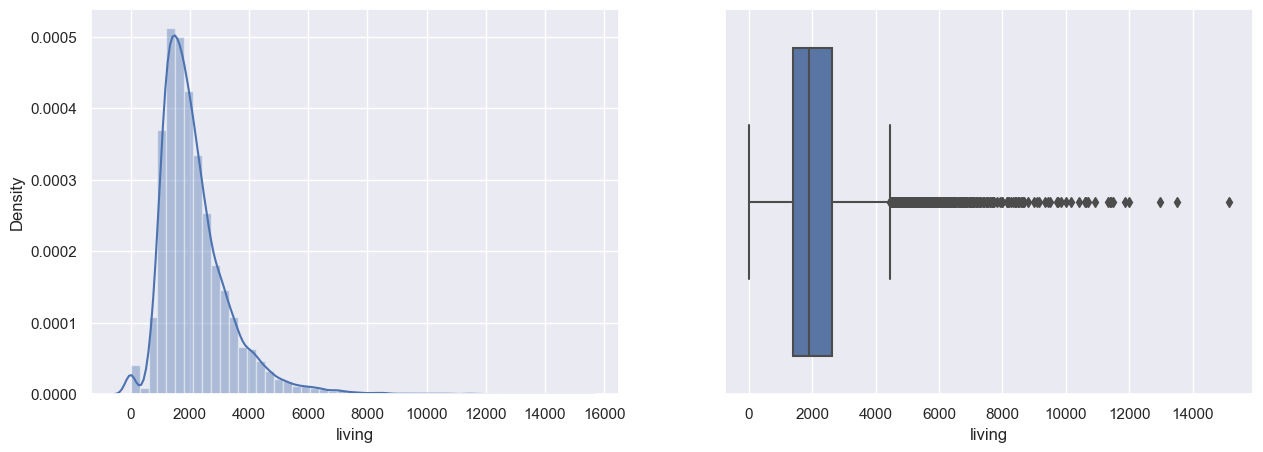

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(df["living"],  ax=axs[0]);
sns.boxplot(df["living"],  ax=axs[1]);

In [16]:
df = df[df['living'] <= 8000]
  
print(len(df))

12662


### tax 

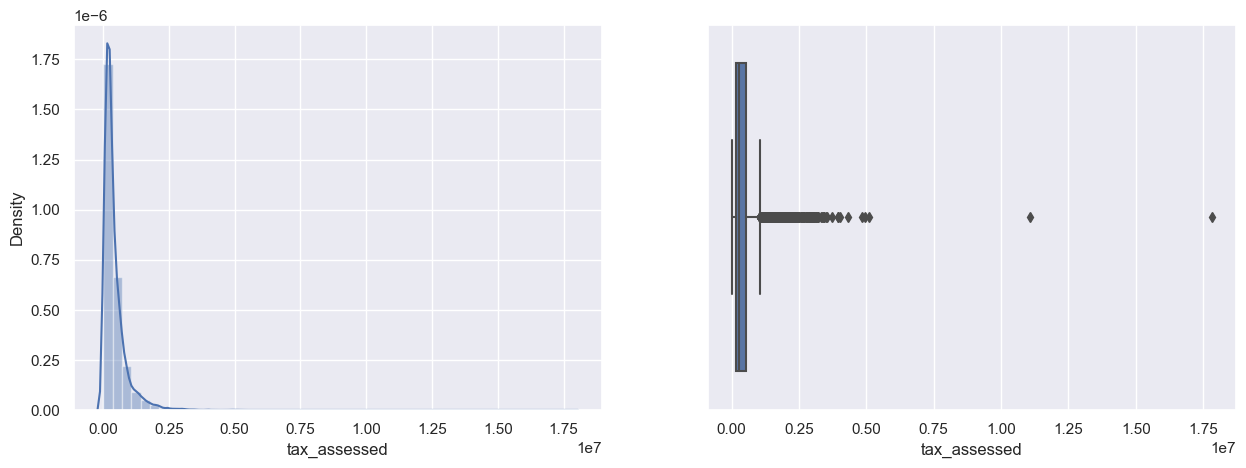

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(df["tax_assessed"],  ax=axs[0]);
sns.boxplot(df["tax_assessed"],  ax=axs[1]);

In [18]:
df = df[df['tax_assessed'] <= 2500000]
  
print(len(df))

12597


### covered

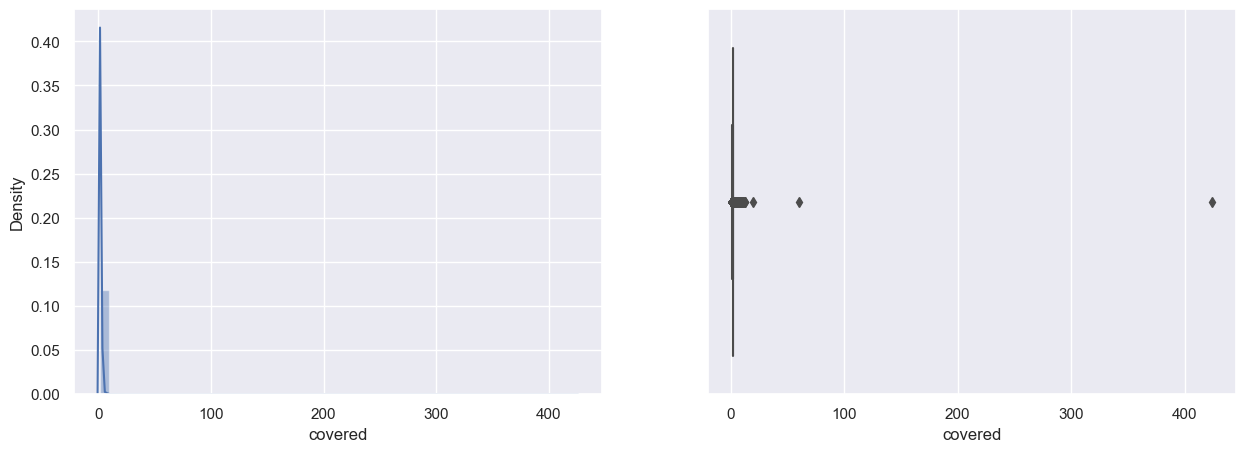

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(df["covered"],  ax=axs[0]);
sns.boxplot(df["covered"],  ax=axs[1]);

In [20]:
find_boxplot_boundaries(df["covered"])

(1.4, 2.36)

In [21]:
df = df[df['covered'] <= 5]
  
print(len(df))

12532


### garage

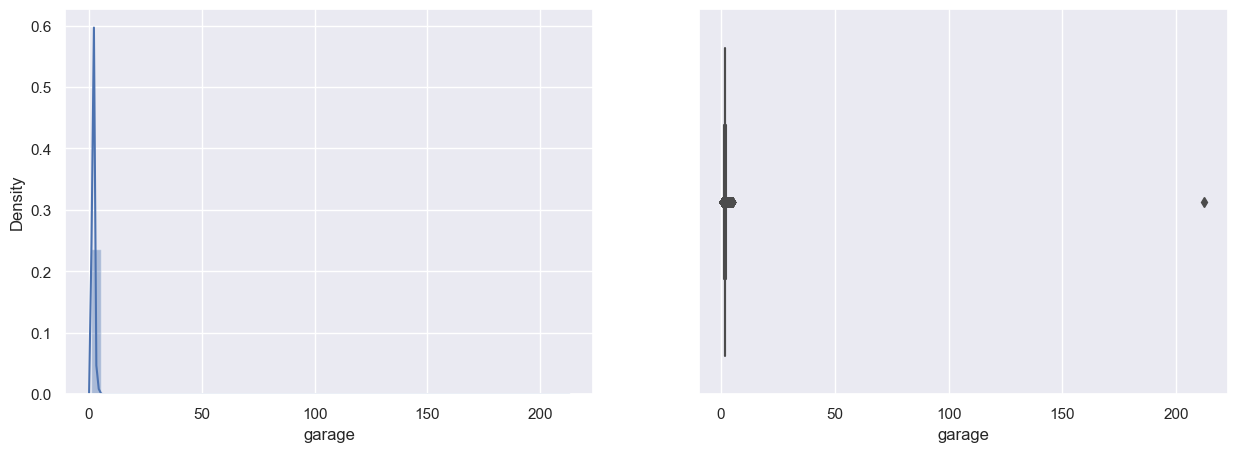

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(df["garage"],  ax=axs[0]);
sns.boxplot(df["garage"],  ax=axs[1]);

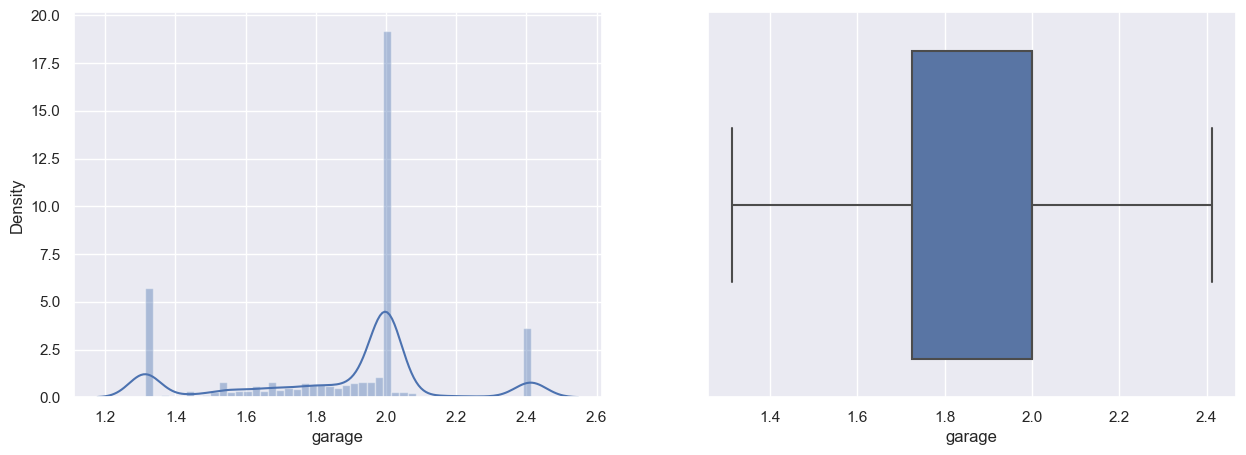

In [23]:
clipped_garage = BoxplotOutlierClipper().fit_transform(df["garage"])

# Plot new data (clipped)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(clipped_garage, ax = axs[0])
sns.boxplot(clipped_garage, ax = axs[1]);

df["garage"] = clipped_garage

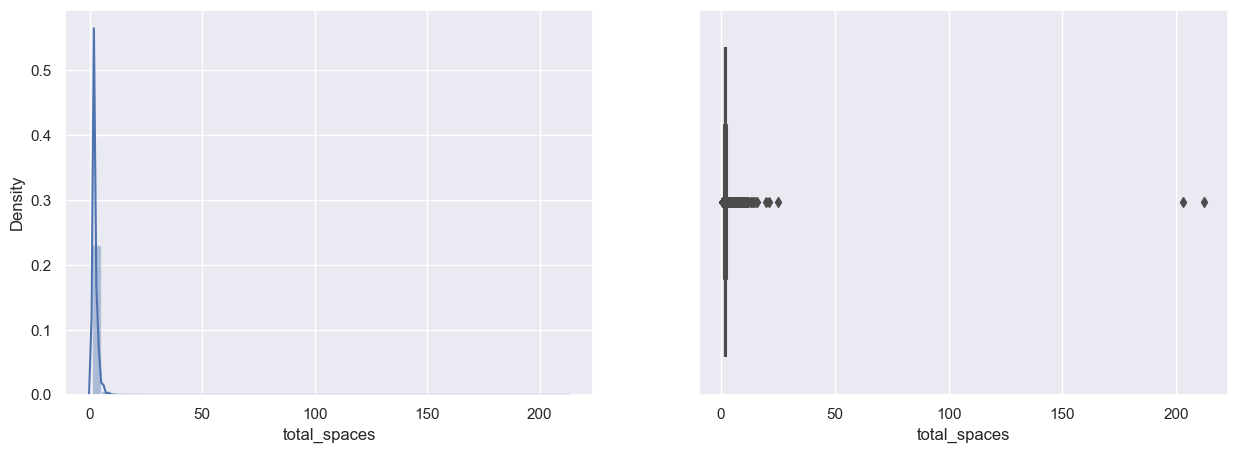

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(df["total_spaces"],  ax=axs[0]);
sns.boxplot(df["total_spaces"],  ax=axs[1]);

## Categorical

### fireplace 

In [25]:
df["fireplace"].unique()

array(['none', 'pellet stoven', 'wood burning stoven', '1.0', '2.0',
       '3.0', 'family room', 'living room', 'non', 'decorative',
       'see remarks', 'great room', 'gas', 'dining room', 'electric',
       'fire pit', 'decorativ', 'rairsed heart', 'librar',
       'master bedroom', 'wood burning', 'bonus room', 'den', 'de',
       'outside', 'game room', '4.0', '5.0', '7.0', '6.0', '9.0', '8.0',
       'other (see remarks)', 'free standing', 'fire pi', 'see through',
       'marble', 'gas/propane', 'free standin', 'insert', 'other',
       'brick', 'not applicable', 'three', 'gas starte', 'bat',
       'see throug', 'gas starter', '1 fireplace', '2 or more fireplaces',
       'brick fireplace', 'family room/den/great room',
       '2 or more fireplace', 'family room/den/great roo',
       'tile fireplace', 'stone fireplace', 'gas log', 'vente',
       'primary bedroom', 'ventles', 'ventless', 'keeping room', 'vented',
       'kitchen', 'hearth room', 'wood burnin', 'other logcatio

In [26]:
def cus_fireplace(df):
    for i in list(df.index):
        if df.at[i, "fireplace"] in ["none", "1 fireplace"]:
            df.at[i, "fireplace"] = int(1)
        elif df.at[i, "fireplace"] == ["not applicable", "non"]:
            df.at[i, "fireplace"] = int(0)
        elif df.at[i, "fireplace"] in ["0.0",'1.0', '2.0', '3.0', '4.0', '5.0', '7.0', '6.0', '9.0', '8.0']:
            df.at[i, "fireplace"] = int(float(df.at[i, "fireplace"]))
        elif df.at[i, "fireplace"] in ["2 or more fireplaces", "2 or more fireplace"]:
            df.at[i, "fireplace"] = int(2)
        elif df.at[i, "fireplace"] in ["2+ fireplace", "three"] :
            df.at[i, "fireplace"] = int(3)
        else:
            df.at[i, "fireplace"] = int(1)
    return df

cus_fireplace(df)

,price,status,add_attr,state,lat,long,bath,bed,living,lot_a,tax_assessed,fireplace,parking,covered,garage,total_spaces,subtype,year,sewer,water,app,heating,cooling,stories,materials,roof,foundation,interior
0,274000,House for sale,True,NY,40.675730,-73.822350,3.0,3,1556,2400.00,0,1,Garage - Detached,1.750,1.5950,1.945,none,1930.0,none,none,none,none,none,0.0,none,none,none,none
1,270000,House for sale,True,NY,40.670036,-73.780450,4.0,4,1920,3998.00,678000,1,none,1.660,1.5350,2.160,none,1950.0,none,none,microwave,none,none,0.0,none,none,none,none
2,899000,House for sale,True,NY,40.524227,-74.215790,3.0,3,2532,6903.00,637000,1,Detache,1.935,2.0000,2.000,Single Family - Detached,1899.0,Public Sewer,none,dishwasher,hot water,Units,2.0,none,none,none,none
3,1390000,House for sale,True,NY,40.721615,-73.820755,4.0,4,1915,2697.00,894000,1,none,1.695,1.6550,3.915,none,1945.0,none,none,dryer,none,none,0.0,none,none,none,none
5,1380000,House for sale,True,NY,40.604470,-73.943960,3.0,3,1800,2000.00,0,1,Shared Drivewa,1.700,1.3125,2.160,Single Family Residence,1930.0,Public Sewer,Public,dishwasher,natural gas,Wall Unit(s),2.0,brick,none,none,Formal Dining Roo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13333,3675000,House for sale,True,TN,36.123570,-86.795580,5.0,5,5704,0.29,961800,1,Concrete Drivewa,1.905,1.8850,2.000,Single Family Residence,1953.0,Public Sewer,Public,built-in microwave,central,Central A/,3.0,brick,Flat,slab,Dining Are
13334,750000,House for sale,True,TN,36.160694,-86.847830,3.0,3,2208,4356.00,563900,1,Drivewa,1.570,1.6900,2.030,Single Family Residence,1951.0,Public Sewer,Public,gas water heater,forced air,Central A/,3.0,brick,none,slab,none
13335,575000,House for sale,True,TN,36.204834,-86.738660,4.0,4,3658,9147.60,0,1,On Stree,1.805,1.7800,2.000,Single Family Residence,1940.0,Public Sewer,Public,dishwasher,forced air,Central A/,3.0,brick,none,slab,Kitchen - Gourme
13336,609000,House for sale,True,TN,36.196106,-86.735115,3.0,3,1950,871.20,0,1,On Street,1.800,1.6850,2.520,Single Family Residence,1925.0,Public Sewer,Public,gas water heater,hot water,Ductless/Mini-Spli,3.0,brick,none,brick/mortar,Ceiling Fan(s)


### drop city 

### parking

In [27]:
df["parking"].unique()

array(['Garage - Detached', 'none', 'Detache', 'Shared Drivewa',
       'Garage - Attached', 'Community Driv', 'Privat', 'No Garag',
       'Private Driv', 'Shared Driv', 'None', 'Off-street',
       'Garage - Detache', 'Carport', 'Carpor', 'Off Street', 'Non',
       'No Garage', 'On Street', 'Built-i', 'Attache', 'Garage - Attache',
       'Off-stree', 'Driveway', 'Garage', 'On-street', 'Drivewa', 'Commo',
       'Stree', 'Public Parkin', 'Othe', 'Other', 'Off Sit',
       'Direct Acces', 'Gate', 'Garag', 'Attached Carpor', 'Attached',
       'Garage - 2 Ca', 'Garage - Single Door', 'Driveway Gat',
       'Concrete', 'Garage Is Attache', 'Garage - 2 Car',
       'Garage - 1 Car', 'Detached Carport', 'Garage Is Detached',
       'Garage - Two Door', 'Converted Garag', 'Above Street Leve',
       'Garage Is Detache', 'Assigne', 'Garage Is Attached', 'Covere',
       'Driveway - Combinatio', 'Garage - 1 Ca', 'Attached Carport',
       'Paver Bloc', 'Garage - Two Doo', 'On Stree', 'Garag

In [28]:
def cus_parking(df):
    for i in list(df.index):
        if df.at[i, "parking"] in ["No Garag", 'No Garage', 'Contact manager', 'Garage: None Know', 'See Remarks',  'Uncovered Parking Spaces 2', 'See Remark', 'Non', 'None']:
            df.at[i, "parking"] = int(0)
        else:
            df.at[i, "parking"] = int(1)
    return df
cus_parking(df)

,price,status,add_attr,state,lat,long,bath,bed,living,lot_a,tax_assessed,fireplace,parking,covered,garage,total_spaces,subtype,year,sewer,water,app,heating,cooling,stories,materials,roof,foundation,interior
0,274000,House for sale,True,NY,40.675730,-73.822350,3.0,3,1556,2400.00,0,1,1,1.750,1.5950,1.945,none,1930.0,none,none,none,none,none,0.0,none,none,none,none
1,270000,House for sale,True,NY,40.670036,-73.780450,4.0,4,1920,3998.00,678000,1,1,1.660,1.5350,2.160,none,1950.0,none,none,microwave,none,none,0.0,none,none,none,none
2,899000,House for sale,True,NY,40.524227,-74.215790,3.0,3,2532,6903.00,637000,1,1,1.935,2.0000,2.000,Single Family - Detached,1899.0,Public Sewer,none,dishwasher,hot water,Units,2.0,none,none,none,none
3,1390000,House for sale,True,NY,40.721615,-73.820755,4.0,4,1915,2697.00,894000,1,1,1.695,1.6550,3.915,none,1945.0,none,none,dryer,none,none,0.0,none,none,none,none
5,1380000,House for sale,True,NY,40.604470,-73.943960,3.0,3,1800,2000.00,0,1,1,1.700,1.3125,2.160,Single Family Residence,1930.0,Public Sewer,Public,dishwasher,natural gas,Wall Unit(s),2.0,brick,none,none,Formal Dining Roo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13333,3675000,House for sale,True,TN,36.123570,-86.795580,5.0,5,5704,0.29,961800,1,1,1.905,1.8850,2.000,Single Family Residence,1953.0,Public Sewer,Public,built-in microwave,central,Central A/,3.0,brick,Flat,slab,Dining Are
13334,750000,House for sale,True,TN,36.160694,-86.847830,3.0,3,2208,4356.00,563900,1,1,1.570,1.6900,2.030,Single Family Residence,1951.0,Public Sewer,Public,gas water heater,forced air,Central A/,3.0,brick,none,slab,none
13335,575000,House for sale,True,TN,36.204834,-86.738660,4.0,4,3658,9147.60,0,1,1,1.805,1.7800,2.000,Single Family Residence,1940.0,Public Sewer,Public,dishwasher,forced air,Central A/,3.0,brick,none,slab,Kitchen - Gourme
13336,609000,House for sale,True,TN,36.196106,-86.735115,3.0,3,1950,871.20,0,1,1,1.800,1.6850,2.520,Single Family Residence,1925.0,Public Sewer,Public,gas water heater,hot water,Ductless/Mini-Spli,3.0,brick,none,brick/mortar,Ceiling Fan(s)


In [29]:
df.head()

,price,status,add_attr,state,lat,long,bath,bed,living,lot_a,tax_assessed,fireplace,parking,covered,garage,total_spaces,subtype,year,sewer,water,app,heating,cooling,stories,materials,roof,foundation,interior
0,274000,House for sale,True,NY,40.675730,-73.822350,3.0,3,1556,2400.0,0,1,1,1.750,1.5950,1.945,none,1930.0,none,none,none,none,none,0.0,none,none,none,none
1,270000,House for sale,True,NY,40.670036,-73.780450,4.0,4,1920,3998.0,678000,1,1,1.660,1.5350,2.160,none,1950.0,none,none,microwave,none,none,0.0,none,none,none,none
2,899000,House for sale,True,NY,40.524227,-74.215790,3.0,3,2532,6903.0,637000,1,1,1.935,2.0000,2.000,Single Family - Detached,1899.0,Public Sewer,none,dishwasher,hot water,Units,2.0,none,none,none,none
3,1390000,House for sale,True,NY,40.721615,-73.820755,4.0,4,1915,2697.0,894000,1,1,1.695,1.6550,3.915,none,1945.0,none,none,dryer,none,none,0.0,none,none,none,none
5,1380000,House for sale,True,NY,40.604470,-73.943960,3.0,3,1800,2000.0,0,1,1,1.700,1.3125,2.160,Single Family Residence,1930.0,Public Sewer,Public,dishwasher,natural gas,Wall Unit(s),2.0,brick,none,none,Formal Dining Roo


### drop lot_f, architectural

In [30]:
df.head()

,price,status,add_attr,state,lat,long,bath,bed,living,lot_a,tax_assessed,fireplace,parking,covered,garage,total_spaces,subtype,year,sewer,water,app,heating,cooling,stories,materials,roof,foundation,interior
0,274000,House for sale,True,NY,40.675730,-73.822350,3.0,3,1556,2400.0,0,1,1,1.750,1.5950,1.945,none,1930.0,none,none,none,none,none,0.0,none,none,none,none
1,270000,House for sale,True,NY,40.670036,-73.780450,4.0,4,1920,3998.0,678000,1,1,1.660,1.5350,2.160,none,1950.0,none,none,microwave,none,none,0.0,none,none,none,none
2,899000,House for sale,True,NY,40.524227,-74.215790,3.0,3,2532,6903.0,637000,1,1,1.935,2.0000,2.000,Single Family - Detached,1899.0,Public Sewer,none,dishwasher,hot water,Units,2.0,none,none,none,none
3,1390000,House for sale,True,NY,40.721615,-73.820755,4.0,4,1915,2697.0,894000,1,1,1.695,1.6550,3.915,none,1945.0,none,none,dryer,none,none,0.0,none,none,none,none
5,1380000,House for sale,True,NY,40.604470,-73.943960,3.0,3,1800,2000.0,0,1,1,1.700,1.3125,2.160,Single Family Residence,1930.0,Public Sewer,Public,dishwasher,natural gas,Wall Unit(s),2.0,brick,none,none,Formal Dining Roo


### sewer, water, app, heating, cooling, materials, roof, foundation, interior


In [31]:
df["sewer"].unique()

array(['none', 'Public Sewer', 'Municipal', 'Sewer', 'Septic Tank', 'Y',
       'Other', 'None', 'Private Sewer', 'Septic Type Unknown',
       'In Street', 'Unknown', 'In Street Paid', 'In Connected and Paid',
       'Public Sewe', 'Cesspool', 'Holding Tan', 'Sewer Connecte',
       'Cesspoo', 'Sewer Paid', 'In Stree', 'Private Sewe',
       'Sewer Connected', 'Septic-Mechanical', 'Sewer-Stor',
       'Sewer-Storm', 'Overhead Sewers', 'Shared Septic', 'Septic Tan',
       'Other Water/Sewe', 'Other Water/Sewer', 'MUD', 'Septic in & Cnct',
       'Septic in & Cnctd', 'Septic-In & Connectd', 'No Septic System',
       'Public Septic', 'On Site Septic', 'Public Septi',
       'No Septic Approved', 'On Site Septi', 'No Sewer System',
       'Public Hook/Up Avail', 'Sewer System', 'SAWS', 'SAW', 'Septic',
       'City', 'Cit', 'Saw', 'CITY', 'Aerobic Septic', 'saw', 'CIT',
       'LEON SPRING', 'City of SA', 'San Antonio', 'SEPTI', 'MJ Septi',
       'Septi', 'saws', 'Not Connected (at lot

In [32]:
def cus_sewer(df):
    for i in list(df.index):
        if df.at[i, "sewer"] in ["None", "Other", "Unknown", 'No Septic Approved', 'No Sewer System','Other/Remark', 'Othe', 'Septic Needed',  'Not Connected (nearby', 'Non', 'No Septic Syste']:
            df.at[i, "sewer"] = int(0)
        else:
            df.at[i, "sewer"] = int(1)
    return df
cus_sewer(df)

,price,status,add_attr,state,lat,long,bath,bed,living,lot_a,tax_assessed,fireplace,parking,covered,garage,total_spaces,subtype,year,sewer,water,app,heating,cooling,stories,materials,roof,foundation,interior
0,274000,House for sale,True,NY,40.675730,-73.822350,3.0,3,1556,2400.00,0,1,1,1.750,1.5950,1.945,none,1930.0,1,none,none,none,none,0.0,none,none,none,none
1,270000,House for sale,True,NY,40.670036,-73.780450,4.0,4,1920,3998.00,678000,1,1,1.660,1.5350,2.160,none,1950.0,1,none,microwave,none,none,0.0,none,none,none,none
2,899000,House for sale,True,NY,40.524227,-74.215790,3.0,3,2532,6903.00,637000,1,1,1.935,2.0000,2.000,Single Family - Detached,1899.0,1,none,dishwasher,hot water,Units,2.0,none,none,none,none
3,1390000,House for sale,True,NY,40.721615,-73.820755,4.0,4,1915,2697.00,894000,1,1,1.695,1.6550,3.915,none,1945.0,1,none,dryer,none,none,0.0,none,none,none,none
5,1380000,House for sale,True,NY,40.604470,-73.943960,3.0,3,1800,2000.00,0,1,1,1.700,1.3125,2.160,Single Family Residence,1930.0,1,Public,dishwasher,natural gas,Wall Unit(s),2.0,brick,none,none,Formal Dining Roo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13333,3675000,House for sale,True,TN,36.123570,-86.795580,5.0,5,5704,0.29,961800,1,1,1.905,1.8850,2.000,Single Family Residence,1953.0,1,Public,built-in microwave,central,Central A/,3.0,brick,Flat,slab,Dining Are
13334,750000,House for sale,True,TN,36.160694,-86.847830,3.0,3,2208,4356.00,563900,1,1,1.570,1.6900,2.030,Single Family Residence,1951.0,1,Public,gas water heater,forced air,Central A/,3.0,brick,none,slab,none
13335,575000,House for sale,True,TN,36.204834,-86.738660,4.0,4,3658,9147.60,0,1,1,1.805,1.7800,2.000,Single Family Residence,1940.0,1,Public,dishwasher,forced air,Central A/,3.0,brick,none,slab,Kitchen - Gourme
13336,609000,House for sale,True,TN,36.196106,-86.735115,3.0,3,1950,871.20,0,1,1,1.800,1.6850,2.520,Single Family Residence,1925.0,1,Public,gas water heater,hot water,Ductless/Mini-Spli,3.0,brick,none,brick/mortar,Ceiling Fan(s)


In [33]:
df["water"].unique()

array(['none', 'Public', 'Municipal', 'See Remarks', 'None', 'Community',
       'Private', 'District', 'Other', 'In Street', 'Meter on Propert',
       'Water District', 'Public Utility', 'Othe', 'Distric', 'Privat',
       'Meter on Property', 'Lake Michiga', 'Lake Michigan',
       'Shared Well', 'Publi', 'Other Water/Sewer', 'Other Water/Sewe',
       'Well', 'MUD', 'City Franchise', 'Water System', 'SAWS', 'SAW',
       'Cit', 'City', 'Saw', 'Private Well', 'East Central', 'saw',
       'City of SA', 'saws', 'San Antoni', 'Atascosa', 'CITY',
       'Not Connected (at lot', 'Co-op Water', 'WEL', 'BEXAR ME',
       'Private Wel', 'City Water', 'Saws', 'Other/Remarks', 'City Wate',
       'Individual Water Meter', 'MUD Water', 'Master Water Meter',
       'Individual Water Mete', 'Meter on Sit', 'Meter on Site',
       'Water On Site', 'Municipal Utility District (MUD)',
       'Municipal Utility District (MUD', 'Wel', 'Cister', 'Central',
       'Co-op Wate', 'County Water', 'Commun

In [34]:
def cus_water(df):
    for i in list(df.index):
        if df.at[i, "water"] in ['None', 'Other', 'Othe', 'Not Connected (at lot', 'Co-op Water']:
            df.at[i, "water"] = int(0)
        else:
            df.at[i, "water"] = int(1)
    return df
cus_water(df)

,price,status,add_attr,state,lat,long,bath,bed,living,lot_a,tax_assessed,fireplace,parking,covered,garage,total_spaces,subtype,year,sewer,water,app,heating,cooling,stories,materials,roof,foundation,interior
0,274000,House for sale,True,NY,40.675730,-73.822350,3.0,3,1556,2400.00,0,1,1,1.750,1.5950,1.945,none,1930.0,1,1,none,none,none,0.0,none,none,none,none
1,270000,House for sale,True,NY,40.670036,-73.780450,4.0,4,1920,3998.00,678000,1,1,1.660,1.5350,2.160,none,1950.0,1,1,microwave,none,none,0.0,none,none,none,none
2,899000,House for sale,True,NY,40.524227,-74.215790,3.0,3,2532,6903.00,637000,1,1,1.935,2.0000,2.000,Single Family - Detached,1899.0,1,1,dishwasher,hot water,Units,2.0,none,none,none,none
3,1390000,House for sale,True,NY,40.721615,-73.820755,4.0,4,1915,2697.00,894000,1,1,1.695,1.6550,3.915,none,1945.0,1,1,dryer,none,none,0.0,none,none,none,none
5,1380000,House for sale,True,NY,40.604470,-73.943960,3.0,3,1800,2000.00,0,1,1,1.700,1.3125,2.160,Single Family Residence,1930.0,1,1,dishwasher,natural gas,Wall Unit(s),2.0,brick,none,none,Formal Dining Roo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13333,3675000,House for sale,True,TN,36.123570,-86.795580,5.0,5,5704,0.29,961800,1,1,1.905,1.8850,2.000,Single Family Residence,1953.0,1,1,built-in microwave,central,Central A/,3.0,brick,Flat,slab,Dining Are
13334,750000,House for sale,True,TN,36.160694,-86.847830,3.0,3,2208,4356.00,563900,1,1,1.570,1.6900,2.030,Single Family Residence,1951.0,1,1,gas water heater,forced air,Central A/,3.0,brick,none,slab,none
13335,575000,House for sale,True,TN,36.204834,-86.738660,4.0,4,3658,9147.60,0,1,1,1.805,1.7800,2.000,Single Family Residence,1940.0,1,1,dishwasher,forced air,Central A/,3.0,brick,none,slab,Kitchen - Gourme
13336,609000,House for sale,True,TN,36.196106,-86.735115,3.0,3,1950,871.20,0,1,1,1.800,1.6850,2.520,Single Family Residence,1925.0,1,1,gas water heater,hot water,Ductless/Mini-Spli,3.0,brick,none,brick/mortar,Ceiling Fan(s)


In [35]:
df["app"].unique()

array(['none', 'microwave', 'dishwasher', 'dryer', 'stoven',
       'range / oven', 'refrigerator', 'oven', 'indoor gridl', 'freeze',
       'gas water heater', 'trash compactor', 'cooktop',
       'stairnless steel appliance(s)',
       'energy star qualified refrigerator', 'stove', 'convection oven',
       'range hoo', 'range/oven', 'disposal', 'barbeque',
       '6 burner stove', 'built-in range', 'washer', 'gas oven',
       'gas cooking appliance', 'gas cooktop', 'free standing gas',
       'built-in gas', 'built-in', 'no cooking appliances',
       'vented exhaust fa', 'double oven', 'water heater',
       'built-in electric', 'gas & electric range', 'range',
       'electric cooktop', 'built-in and free standin',
       'gas/electric range', 'gas range', 'electric range',
       'bar ice make', 'water heater unit', '6 burner stoven',
       'free-standing range', 'high end refrigerator', 'humidifier',
       'freestanding oven', 'energy star qualified appliance',
       'electr

In [36]:
df["heating"].unique()

array(['none', 'hot water', 'natural gas', 'radian', 'other', 'baseboard',
       'heat pump', 'forced air', 'oil', 'steam', 'baseboar', 'gas',
       'electric', 'radiant', 'central', 'wall', 'fireplace(s',
       'wall furnace', 'flogor furnace', 'gravity', 'flogor furnac',
       'has heating (unspecified type)', 'see remarks', 'space heater',
       'energy star qualified equipment', 'fireplace(s)',
       'central heat/gas', 'combination', 'geothermal', 'radiator(s)',
       'radiator(s', 'propane', 'other-see remarks', 'window unit',
       'ceiling', 'wall/flogor heat', 'radiator', 'baseboard - hot water',
       '90% forced air', 'zone', 'baseboard - electric', 'non',
       'heat pump - electric backup', 'heat pump - gas backup',
       'programmable thermosta', 'active sola', 'ye', '3+ unit',
       'central electric', 'pane', '90% efficient furnace', '2 unit',
       '1 unit', 'wall heater', 'multiple heating unit',
       'other heat source (see remarks)', 'other/remark',
 

In [37]:
def cus_heating(df):
    for i in list(df.index):
        if df.at[i, "heating"] in ['other', 'see remarks', 'other/remark', 'other-see remark']:
            df.at[i, "heating"] = int(0)
        else:
            df.at[i, "heating"] = int(1)
    return df
cus_heating(df)

,price,status,add_attr,state,lat,long,bath,bed,living,lot_a,tax_assessed,fireplace,parking,covered,garage,total_spaces,subtype,year,sewer,water,app,heating,cooling,stories,materials,roof,foundation,interior
0,274000,House for sale,True,NY,40.675730,-73.822350,3.0,3,1556,2400.00,0,1,1,1.750,1.5950,1.945,none,1930.0,1,1,none,1,none,0.0,none,none,none,none
1,270000,House for sale,True,NY,40.670036,-73.780450,4.0,4,1920,3998.00,678000,1,1,1.660,1.5350,2.160,none,1950.0,1,1,microwave,1,none,0.0,none,none,none,none
2,899000,House for sale,True,NY,40.524227,-74.215790,3.0,3,2532,6903.00,637000,1,1,1.935,2.0000,2.000,Single Family - Detached,1899.0,1,1,dishwasher,1,Units,2.0,none,none,none,none
3,1390000,House for sale,True,NY,40.721615,-73.820755,4.0,4,1915,2697.00,894000,1,1,1.695,1.6550,3.915,none,1945.0,1,1,dryer,1,none,0.0,none,none,none,none
5,1380000,House for sale,True,NY,40.604470,-73.943960,3.0,3,1800,2000.00,0,1,1,1.700,1.3125,2.160,Single Family Residence,1930.0,1,1,dishwasher,1,Wall Unit(s),2.0,brick,none,none,Formal Dining Roo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13333,3675000,House for sale,True,TN,36.123570,-86.795580,5.0,5,5704,0.29,961800,1,1,1.905,1.8850,2.000,Single Family Residence,1953.0,1,1,built-in microwave,1,Central A/,3.0,brick,Flat,slab,Dining Are
13334,750000,House for sale,True,TN,36.160694,-86.847830,3.0,3,2208,4356.00,563900,1,1,1.570,1.6900,2.030,Single Family Residence,1951.0,1,1,gas water heater,1,Central A/,3.0,brick,none,slab,none
13335,575000,House for sale,True,TN,36.204834,-86.738660,4.0,4,3658,9147.60,0,1,1,1.805,1.7800,2.000,Single Family Residence,1940.0,1,1,dishwasher,1,Central A/,3.0,brick,none,slab,Kitchen - Gourme
13336,609000,House for sale,True,TN,36.196106,-86.735115,3.0,3,1950,871.20,0,1,1,1.800,1.6850,2.520,Single Family Residence,1925.0,1,1,gas water heater,1,Ductless/Mini-Spli,3.0,brick,none,brick/mortar,Ceiling Fan(s)


In [38]:
df["cooling"].unique()

array(['none', 'Units', 'Wall Unit(s)', 'Central', 'None', 'Central Air',
       'Window Unit(s)', 'Zoned', 'Other', 'Ductless', 'Wall',
       'Wall Unit(s', 'A/C Unit', 'Centra', 'Ductles', 'A/C Uni',
       'Central Ai', 'Zone', 'Central Air - Split', 'Air Conditionin',
       'Wall/Window Unit(s)', 'Air Conditioning', 'Ceiling Fan(s',
       'Window Unit(s', 'Ceiling Fan(s)', 'See Remarks', 'Attic Fa',
       'Evaporative Cooling', 'See Remark', 'Central Air/Refrig', 'Dual',
       'Non', 'Whole House Fans', 'Window/Wall Units - 2',
       'Window/Wall Unit - 1', 'Window/Wall Units - 3+', 'Space Pac',
       'Space Pa', 'Window/Wall Units - ', 'Partial', 'Ga', 'Electri',
       'Electric', 'Gas', 'Heat Pum', 'Central Electric', 'Refrigeration',
       'Programmable Thmsta', 'Refrigeratio', 'Othe', 'Both Refrig & Eva',
       'Refrigerator', 'Mini Spli', 'ENERGY STAR Qualified Equipmen',
       'Both Refrig & Evap', 'Evaporative Coolin', 'Central A/',
       'Ductless/Mini-Spli', 'C

In [39]:
def cus_cooling(df):
    for i in list(df.index):
        if df.at[i, "cooling"] in ['None', 'Other', 'Ductless', 'See Remark', 'Non', 'Ductless/Mini-Spli', 'Other/Remark', 'No Air Conditioning', 'Other-See Remarks']:
            df.at[i, "cooling"] = int(0)
        else:
            df.at[i, "cooling"] = int(1)
    return df
cus_cooling(df)

,price,status,add_attr,state,lat,long,bath,bed,living,lot_a,tax_assessed,fireplace,parking,covered,garage,total_spaces,subtype,year,sewer,water,app,heating,cooling,stories,materials,roof,foundation,interior
0,274000,House for sale,True,NY,40.675730,-73.822350,3.0,3,1556,2400.00,0,1,1,1.750,1.5950,1.945,none,1930.0,1,1,none,1,1,0.0,none,none,none,none
1,270000,House for sale,True,NY,40.670036,-73.780450,4.0,4,1920,3998.00,678000,1,1,1.660,1.5350,2.160,none,1950.0,1,1,microwave,1,1,0.0,none,none,none,none
2,899000,House for sale,True,NY,40.524227,-74.215790,3.0,3,2532,6903.00,637000,1,1,1.935,2.0000,2.000,Single Family - Detached,1899.0,1,1,dishwasher,1,1,2.0,none,none,none,none
3,1390000,House for sale,True,NY,40.721615,-73.820755,4.0,4,1915,2697.00,894000,1,1,1.695,1.6550,3.915,none,1945.0,1,1,dryer,1,1,0.0,none,none,none,none
5,1380000,House for sale,True,NY,40.604470,-73.943960,3.0,3,1800,2000.00,0,1,1,1.700,1.3125,2.160,Single Family Residence,1930.0,1,1,dishwasher,1,1,2.0,brick,none,none,Formal Dining Roo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13333,3675000,House for sale,True,TN,36.123570,-86.795580,5.0,5,5704,0.29,961800,1,1,1.905,1.8850,2.000,Single Family Residence,1953.0,1,1,built-in microwave,1,1,3.0,brick,Flat,slab,Dining Are
13334,750000,House for sale,True,TN,36.160694,-86.847830,3.0,3,2208,4356.00,563900,1,1,1.570,1.6900,2.030,Single Family Residence,1951.0,1,1,gas water heater,1,1,3.0,brick,none,slab,none
13335,575000,House for sale,True,TN,36.204834,-86.738660,4.0,4,3658,9147.60,0,1,1,1.805,1.7800,2.000,Single Family Residence,1940.0,1,1,dishwasher,1,1,3.0,brick,none,slab,Kitchen - Gourme
13336,609000,House for sale,True,TN,36.196106,-86.735115,3.0,3,1950,871.20,0,1,1,1.800,1.6850,2.520,Single Family Residence,1925.0,1,1,gas water heater,1,0,3.0,brick,none,brick/mortar,Ceiling Fan(s)


In [40]:
# encode status & state
df["status"] = df.status.astype('category').cat.codes
df["state"] = df.state.astype('category').cat.codes
df.head()

,price,status,add_attr,state,lat,long,bath,bed,living,lot_a,tax_assessed,fireplace,parking,covered,garage,total_spaces,subtype,year,sewer,water,app,heating,cooling,stories,materials,roof,foundation,interior
0,274000,4,True,8,40.675730,-73.822350,3.0,3,1556,2400.0,0,1,1,1.750,1.5950,1.945,none,1930.0,1,1,none,1,1,0.0,none,none,none,none
1,270000,4,True,8,40.670036,-73.780450,4.0,4,1920,3998.0,678000,1,1,1.660,1.5350,2.160,none,1950.0,1,1,microwave,1,1,0.0,none,none,none,none
2,899000,4,True,8,40.524227,-74.215790,3.0,3,2532,6903.0,637000,1,1,1.935,2.0000,2.000,Single Family - Detached,1899.0,1,1,dishwasher,1,1,2.0,none,none,none,none
3,1390000,4,True,8,40.721615,-73.820755,4.0,4,1915,2697.0,894000,1,1,1.695,1.6550,3.915,none,1945.0,1,1,dryer,1,1,0.0,none,none,none,none
5,1380000,4,True,8,40.604470,-73.943960,3.0,3,1800,2000.0,0,1,1,1.700,1.3125,2.160,Single Family Residence,1930.0,1,1,dishwasher,1,1,2.0,brick,none,none,Formal Dining Roo


In [41]:
# df["subtype"].unique()

def cus_subtype(df):
    for i in list(df.index):
        if df.at[i, "subtype"] in ["none"]:
            df.at[i, "subtype"] = int(0)
        elif df.at[i, "subtype"] in ['Single Family - Detached', 'Single Family Residence', 'Single Family - Semi-Attached', 'Single Family - Attached', 'Single Family Residenc', 'Single Family Shared Wall', ]:
            df.at[i, "subtype"] = int(1)
        else:
            df.at[i, "subtype"] = int(2)
    return df
cus_subtype(df)

,price,status,add_attr,state,lat,long,bath,bed,living,lot_a,tax_assessed,fireplace,parking,covered,garage,total_spaces,subtype,year,sewer,water,app,heating,cooling,stories,materials,roof,foundation,interior
0,274000,4,True,8,40.675730,-73.822350,3.0,3,1556,2400.00,0,1,1,1.750,1.5950,1.945,0,1930.0,1,1,none,1,1,0.0,none,none,none,none
1,270000,4,True,8,40.670036,-73.780450,4.0,4,1920,3998.00,678000,1,1,1.660,1.5350,2.160,0,1950.0,1,1,microwave,1,1,0.0,none,none,none,none
2,899000,4,True,8,40.524227,-74.215790,3.0,3,2532,6903.00,637000,1,1,1.935,2.0000,2.000,1,1899.0,1,1,dishwasher,1,1,2.0,none,none,none,none
3,1390000,4,True,8,40.721615,-73.820755,4.0,4,1915,2697.00,894000,1,1,1.695,1.6550,3.915,0,1945.0,1,1,dryer,1,1,0.0,none,none,none,none
5,1380000,4,True,8,40.604470,-73.943960,3.0,3,1800,2000.00,0,1,1,1.700,1.3125,2.160,1,1930.0,1,1,dishwasher,1,1,2.0,brick,none,none,Formal Dining Roo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13333,3675000,4,True,11,36.123570,-86.795580,5.0,5,5704,0.29,961800,1,1,1.905,1.8850,2.000,1,1953.0,1,1,built-in microwave,1,1,3.0,brick,Flat,slab,Dining Are
13334,750000,4,True,11,36.160694,-86.847830,3.0,3,2208,4356.00,563900,1,1,1.570,1.6900,2.030,1,1951.0,1,1,gas water heater,1,1,3.0,brick,none,slab,none
13335,575000,4,True,11,36.204834,-86.738660,4.0,4,3658,9147.60,0,1,1,1.805,1.7800,2.000,1,1940.0,1,1,dishwasher,1,1,3.0,brick,none,slab,Kitchen - Gourme
13336,609000,4,True,11,36.196106,-86.735115,3.0,3,1950,871.20,0,1,1,1.800,1.6850,2.520,1,1925.0,1,1,gas water heater,1,0,3.0,brick,none,brick/mortar,Ceiling Fan(s)


In [42]:
df.add_attr = df.add_attr.replace({True: 1, False: 0})
df

,price,status,add_attr,state,lat,long,bath,bed,living,lot_a,tax_assessed,fireplace,parking,covered,garage,total_spaces,subtype,year,sewer,water,app,heating,cooling,stories,materials,roof,foundation,interior
0,274000,4,1,8,40.675730,-73.822350,3.0,3,1556,2400.00,0,1,1,1.750,1.5950,1.945,0,1930.0,1,1,none,1,1,0.0,none,none,none,none
1,270000,4,1,8,40.670036,-73.780450,4.0,4,1920,3998.00,678000,1,1,1.660,1.5350,2.160,0,1950.0,1,1,microwave,1,1,0.0,none,none,none,none
2,899000,4,1,8,40.524227,-74.215790,3.0,3,2532,6903.00,637000,1,1,1.935,2.0000,2.000,1,1899.0,1,1,dishwasher,1,1,2.0,none,none,none,none
3,1390000,4,1,8,40.721615,-73.820755,4.0,4,1915,2697.00,894000,1,1,1.695,1.6550,3.915,0,1945.0,1,1,dryer,1,1,0.0,none,none,none,none
5,1380000,4,1,8,40.604470,-73.943960,3.0,3,1800,2000.00,0,1,1,1.700,1.3125,2.160,1,1930.0,1,1,dishwasher,1,1,2.0,brick,none,none,Formal Dining Roo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13333,3675000,4,1,11,36.123570,-86.795580,5.0,5,5704,0.29,961800,1,1,1.905,1.8850,2.000,1,1953.0,1,1,built-in microwave,1,1,3.0,brick,Flat,slab,Dining Are
13334,750000,4,1,11,36.160694,-86.847830,3.0,3,2208,4356.00,563900,1,1,1.570,1.6900,2.030,1,1951.0,1,1,gas water heater,1,1,3.0,brick,none,slab,none
13335,575000,4,1,11,36.204834,-86.738660,4.0,4,3658,9147.60,0,1,1,1.805,1.7800,2.000,1,1940.0,1,1,dishwasher,1,1,3.0,brick,none,slab,Kitchen - Gourme
13336,609000,4,1,11,36.196106,-86.735115,3.0,3,1950,871.20,0,1,1,1.800,1.6850,2.520,1,1925.0,1,1,gas water heater,1,0,3.0,brick,none,brick/mortar,Ceiling Fan(s)


In [43]:
df["app"] = df.status.astype('category').cat.codes
df["materials"] = df.state.astype('category').cat.codes
df["roof"] = df.status.astype('category').cat.codes
df["foundation"] = df.status.astype('category').cat.codes
df["interior"] = df.state.astype('category').cat.codes

In [44]:
df["year"] = df["year"].astype("int8")

In [45]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool

def catboost_drop_features(features):
    # id and label (not features)
    unused_feature_list = ['price']

    # Hurts performance
    unused_feature_list += ['lat', 'long']

    return features.drop(unused_feature_list, axis=1, errors='ignore')

# Drop useless feature
catboost_features = catboost_drop_features(df)
print("Number of features for CatBoost: {}".format(len(catboost_features.columns)))
catboost_features.head()

Number of features for CatBoost: 25


,status,add_attr,state,bath,bed,living,lot_a,tax_assessed,fireplace,parking,covered,garage,total_spaces,subtype,year,sewer,water,app,heating,cooling,stories,materials,roof,foundation,interior
0,4,1,8,3.0,3,1556,2400.0,0,1,1,1.750,1.5950,1.945,0,-118,1,1,4,1,1,0.0,8,4,4,8
1,4,1,8,4.0,4,1920,3998.0,678000,1,1,1.660,1.5350,2.160,0,-98,1,1,4,1,1,0.0,8,4,4,8
2,4,1,8,3.0,3,2532,6903.0,637000,1,1,1.935,2.0000,2.000,1,107,1,1,4,1,1,2.0,8,4,4,8
3,4,1,8,4.0,4,1915,2697.0,894000,1,1,1.695,1.6550,3.915,0,-103,1,1,4,1,1,0.0,8,4,4,8
5,4,1,8,3.0,3,1800,2000.0,0,1,1,1.700,1.3125,2.160,1,-118,1,1,4,1,1,2.0,8,4,4,8


In [46]:
catboost_features.columns

Index(['status', 'add_attr', 'state', 'bath', 'bed', 'living', 'lot_a',
       'tax_assessed', 'fireplace', 'parking', 'covered', 'garage',
       'total_spaces', 'subtype', 'year', 'sewer', 'water', 'app', 'heating',
       'cooling', 'stories', 'materials', 'roof', 'foundation', 'interior'],
      dtype='object')

In [47]:
# Specify feature names and categorical features for CatBoost
feature_names = [s for s in catboost_features.columns]
categorical_features = ['status', 'add_attr', 'state', 'year', 'fireplace', 'parking', "subtype", 'sewer', 'water', 'app', 'heating',
       'cooling', 'materials', 'roof', 'foundation', 'interior']

categorical_indices = []
for index, name_col in enumerate(catboost_features.columns):
    if name_col in categorical_features:
        categorical_indices.append(index)
categorical_indices

[0, 1, 2, 8, 9, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24]

In [48]:
# Prepare training and cross-validation data
# Label Catboost: Log error
catboost_label = df.price.astype(np.float32)

# Transform to Numpy matrices
catboost_X = catboost_features
catboost_y = pd.DataFrame(catboost_label)

# Perform shuffled train/test split
np.random.seed(42)
random.seed(10)
X_train, X_val, y_train, y_val = train_test_split(catboost_X, catboost_y, test_size=0.1)

# Remove outlier examples from X_train and y_train
# Keep them in X_val and y_val for proper cross-validation
#outlier_threshold = 0.4
#mask = (abs(y_train) <= outlier_threshold)
#X_train = X_train.loc[mask]
#y_train = y_train[mask]

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}\n".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (11278, 25)
y_train shape: (11278, 1)

X_val shape: (1254, 25)
y_val shape: (1254, 1)


In [51]:
# CatBoost parameters (Fine-tuning)
params = {}
params['loss_function'] = 'RMSE'
params['eval_metric'] = 'RMSE'
params['nan_mode'] = 'Min'              # Method to handle NaN (set NaN to either Min or Max)
params['random_seed'] = 42

params['iterations'] = 1000             # default 1000, use early stopping during training
params['learning_rate'] = 0.015         # default 0.03

params['border_count'] = 254            # default 254 (alias max_bin, suggested to keep at default for best quality)

params['max_depth'] = 6                 # default 6 (must be <= 16, 6 to 10 is recommended)
params['random_strength'] = 1           # default 1 (used during splitting to deal with over fitting, try different values)
params['l2_leaf_reg'] = 5               # default 3 (used for leaf value calculation, try different values)
params['bagging_temperature'] = 1       # default 1 (higher value -> more aggressive bagging, try different values)

In [56]:
abs(model.predict(X_train).reshape(-1,1) - y_train).mean()

price    154505.013899
dtype: float64

In [52]:
# Train CatBoost Regressor with cross-validated early-stopping
val_pool = Pool(X_val, y_val, cat_features = categorical_indices)

# Training with seed random
np.random.seed(42)
random.seed(36)
model = CatBoostRegressor(**params)

# Training
model.fit(X_train, y_train,
          cat_features=categorical_indices,
          use_best_model=True, eval_set=val_pool, early_stopping_rounds=50, verbose=False)

# Evaluate model performance
print("Train score: {}".format(abs(model.predict(X_train).reshape(-1,1) - y_train).mean() * 100))
print("Val score: {}".format(abs(model.predict(X_val).reshape(-1,1) - y_val).mean() * 100))

Train score: price    1.545050e+07
dtype: float64
Val score: price    1.424624e+07
dtype: float64


In [57]:
# CatBoost feature importance
feature_importance = [(feature_names[i], value) for i, value in enumerate(model.get_feature_importance())]
feature_importance.sort(key=lambda x: x[1], reverse=True)
for k, v in feature_importance[:10]:
    print("{}: {}".format(k, v))

tax_assessed: 30.635575301807275
living: 29.55977637362059
interior: 11.029913788066205
state: 10.938072697111942
materials: 10.004235246555805
subtype: 1.8312767016195752
add_attr: 1.319273089133619
bath: 0.7692188400197826
foundation: 0.6754573503031502
bed: 0.6346350792599693


In [59]:
bags = 20
models = []
params['iterations'] = 1500
for i in range(bags):
    print("Start training model {}".format(i))
    params['random_seed'] = i
    np.random.seed(42)
    random.seed(36)
    model = CatBoostRegressor(**params)
    model.fit(catboost_X, catboost_y, cat_features=categorical_indices, verbose=False)
    models.append(model)

# Sanity check (make sure scores on a small portion of the dataset are reasonable)
for i, model in enumerate(models):
    print("model {}: {}".format(i, abs(model.predict(X_val).reshape(-1,1) - y_val).mean() * 100))

Start training model 0
Start training model 1
Start training model 2
Start training model 3
Start training model 4
Start training model 5
Start training model 6
Start training model 7
Start training model 8
Start training model 9
Start training model 10
Start training model 11
Start training model 12
Start training model 13
Start training model 14
Start training model 15
Start training model 16
Start training model 17
Start training model 18
Start training model 19
model 0: price    1.297100e+07
dtype: float64
model 1: price    1.314078e+07
dtype: float64
model 2: price    1.293738e+07
dtype: float64
model 3: price    1.304384e+07
dtype: float64
model 4: price    1.298163e+07
dtype: float64
model 5: price    1.319703e+07
dtype: float64
model 6: price    1.299893e+07
dtype: float64
model 7: price    1.295355e+07
dtype: float64
model 8: price    1.303520e+07
dtype: float64
model 9: price    1.306178e+07
dtype: float64
model 10: price    1.313390e+07
dtype: float64
model 11: price    1.30

In [83]:
result = pd.DataFrame(abs(model.predict(X_val).reshape(-1,1) - y_val).astype(int))
result.head(30)

,price
12411,175961
3368,316346
10200,395101
10559,2246
11118,24458
486,106688
3552,45087
2579,129155
7875,92774
4526,34193


In [82]:
result.describe()

,price
count,1.254000e+03
mean,1.312088e+05
std,1.784537e+05
min,1.000000e+00
25%,3.246950e+04
50%,7.257750e+04
75%,1.571168e+05
max,2.234769e+06


In [65]:
pd.DataFrame(model.predict(X_val)).head()

,0
0,7.059615e+05
1,8.336535e+05
2,8.371012e+05
3,3.311466e+05
4,1.022458e+06


In [66]:
pd.DataFrame(y_val).head(10)

,price
12411,530000.0
3368,1150000.0
10200,442000.0
10559,328900.0
11118,998000.0


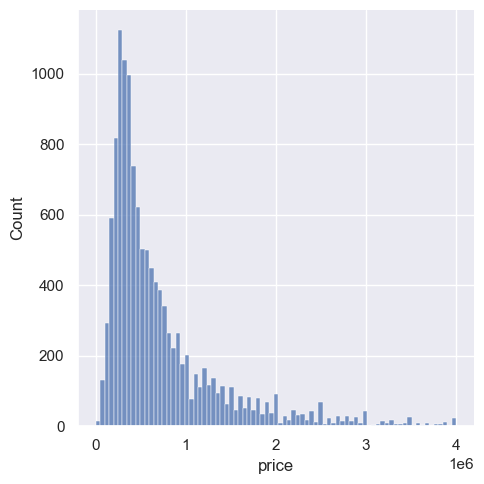

In [60]:
sns.displot(df["price"])

In [ ]:
#file_name = "/Users/charles/Desktop/DSAI/6_DataScience/project/DSP/20221/data/final_catboost_ensemble_x20-1050.csv"
#submission, pred_2016, pred_2017 = catboost_mod.predict_and_export(models, features_2016, features_2017, file_name)